In [1]:
import cv2
from os import listdir
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomTranslation
from keras.models import Sequential
from tqdm import tqdm
import requests

In [2]:
images_path = "../asset/data/images/"
files = listdir(f"{images_path}banana"), listdir(f"{images_path}other")

## Function's declaration to:
Collect, load, generate, normalize, display and get stats of the data

In [10]:
def collect_data():
    """
    Used to collect more random images and increase the dataset
    """
    for i in tqdm(range(2000)):
        url = "https://picsum.photos/224/224/?random"
        response = requests.get(url)
        if response.status_code == 200:
            file_name = 'other_{}.jpg'.format(i)
            file_path = images_path + "other/" + file_name
            with open(file_path, 'wb') as f:
                f.write(response.content)

def load_data():
    """
    Get features and labels + bananas_images for later data augmentation
    :return: X, y, X[class==1]
    """
    images_banana = np.array([cv2.imread(f"{images_path}banana/{file}") for file in files[0]], dtype="object")
    images_others = np.array([cv2.imread(f"{images_path}other/{file}") for file in files[1]], dtype="object")

    y_banana = np.ones((len(images_banana)))
    y_other = np.zeros((len(images_others)))

    X = np.hstack((images_banana, images_others))
    y = np.hstack((y_banana, y_other))
    return X, y, images_banana

def data_augmentation(imgs, new_sample_per_imgs):
    """
    Create new samples of bananas
    :param imgs: bananas images
    :param new_sample_per_imgs: number of new sample per images
    :return: X_augmented
    """
    news_images = []
    augmentation = Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.3),
        RandomTranslation(height_factor=0.25, width_factor=0.25, fill_mode="wrap"),
        RandomContrast(0.2)])
    for i in tqdm(range(len(imgs))):
        for _ in range(new_sample_per_imgs):
            augmented = augmentation(imgs[i])
            news_images.append(np.array(augmented))
    return np.array(news_images)

def image_normalization(images, target_shape=(224, 224)):
    """
    Process used to normalize images
    :param images: X
    :param target_shape: shape of the normalized image
    :return: X_scaled
    """
    new_images = []
    for img in images:
        new_img = cv2.resize(img, target_shape)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_BGRA2BGR)
        # new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
        # new_img = cv2.cvtColor(new_img, cv2.COLOR_GRAY2RGB)
        new_img = new_img/255
        new_img = new_img[..., ::-1]
        new_images.append(new_img)
    return np.array(new_images)

def get_images_stats(images):
    """
    Helper function used to show stats of data
    :param images: X
    :return: number of sample, mean/median width/height
    """
    shapes = []
    for img in images:
        shapes.append(img.shape)
    shapes = np.array(shapes)
    nb_samples = len(shapes)
    mean_w, mean_h = shapes[:, 0].mean(), shapes[:, 1].mean()
    median_w, median_h = np.median(shapes[:, 0]), np.median(shapes[:, 1])
    return nb_samples, (mean_w, mean_h), (median_w, mean_h)

def show_few_images(imgs, labels):
    """
    Helper function used to display few images
    :param imgs: X
    :param labels: y
    """
    randomize = np.arange(len(imgs))
    np.random.shuffle(randomize)
    _imgs = imgs[randomize]
    _labels = labels[randomize]

    fig, axes = plt.subplots(figsize=(15, 15), nrows=1, ncols=10, dpi=120)
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.set_axis_off()
        ax.set_title(_labels[i])
        ax.imshow(_imgs[i])

In [4]:
# collect_data()

100%|██████████| 2000/2000 [15:30<00:00,  2.15it/s]  


In [5]:
X, y, images_banana = load_data()

n_samples, mean_stats, median_stats = get_images_stats(X)

print("Number of images: {nb} \nAverage stats (w,h): {mean} \nMedian stats (w,h): {median}".format(nb=n_samples, mean=tuple(map(round, mean_stats)), median=tuple(map(round, median_stats))))

Number of images: 6109 
Average stats (w,h): (296, 345) 
Median stats (w,h): (256, 345)


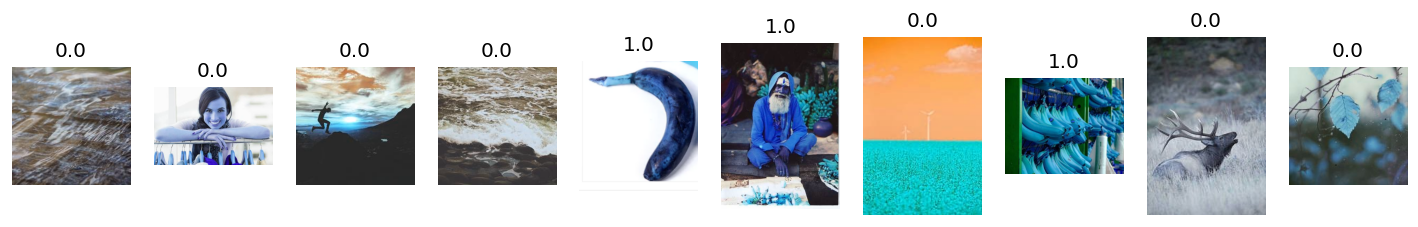

In [6]:
show_few_images(X, y)

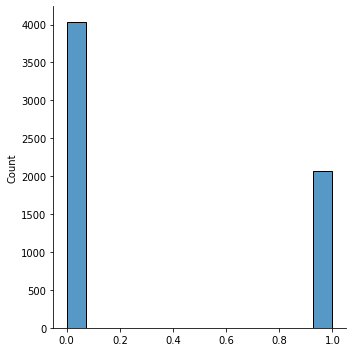

In [7]:
# There is showed that non bananas images are more representative in the dataset
sns.displot(y)

In [8]:
# Normalize bananas images only to make data augmentation and make a right distribution of the classes
images_banana_scaled = image_normalization(images_banana)

In [11]:
images_banana_augmented = data_augmentation(images_banana_scaled, 1)

100%|██████████| 2072/2072 [00:34<00:00, 59.69it/s]


In [13]:
X_scaled = image_normalization(X)
images_banana_augmented.shape, X_scaled.shape

((2072, 224, 224, 3), (6109, 224, 224, 3))

In [14]:
X_new = np.vstack((X_scaled, images_banana_augmented))
y_new = np.hstack((y, np.ones(len(images_banana_augmented))))
X_new.shape, y_new.shape

((8181, 224, 224, 3), (8181,))

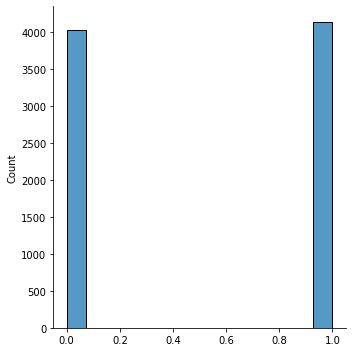

In [15]:
sns.displot(y_new)

In [16]:
n_samples, mean_stats, median_stats = get_images_stats(X_new)

print("Number of images: {nb} \nAverage stats (w,h): {mean} \nMedian stats (w,h): {median}".format(nb=n_samples, mean=tuple(map(round, mean_stats)), median=tuple(map(round, median_stats))))

Number of images: 8181 
Average stats (w,h): (224, 224) 
Median stats (w,h): (224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


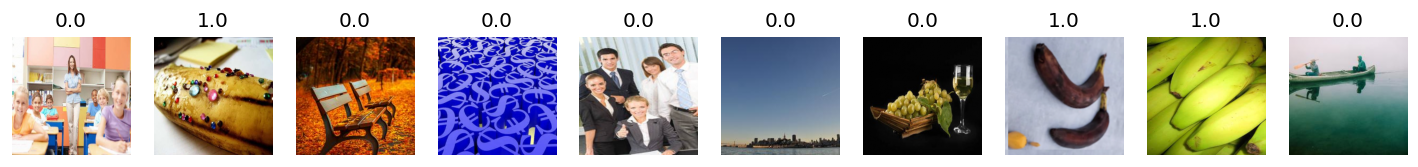

In [17]:
show_few_images(X_new, y_new)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=.2)
X_train.shape, y_train.shape

((6544, 224, 224, 3), (6544,))

In [19]:
data = {"train": (X_train, y_train), "test": (X_test, y_test)}

In [20]:
with open(f'../asset/data/train_test_split.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)